<a href="https://colab.research.google.com/github/rul124/Capstone-MSED/blob/main/HubertBase_Last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1+cu113
0.12.1+cu113
cpu


In [4]:
bundle = torchaudio.pipelines.HUBERT_BASE
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/hubert_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/hubert_fairseq_base_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [5]:
bundle.sample_rate

16000

### Feature Preparation

In [6]:
# Define path to datasets
DATA_NATURAL = "/content/drive/MyDrive/MESD/MESD_All"
entries = os.listdir(DATA_NATURAL)
print("First:", entries[0])

First: Anger_C_B_alterado.wav


In [7]:
sample_file = DATA_NATURAL + "/" + entries[0]
print("Sample file is:", sample_file)
sample_wave, sr = torchaudio.load(sample_file)
sample_wave = sample_wave.to(device)
if sr != bundle.sample_rate:
    sample_wave = torchaudio.functional.resample(sample_wave, sr, bundle.sample_rate)

with torch.inference_mode():
    features, _ = model.extract_features(sample_wave)

Sample file is: /content/drive/MyDrive/MESD/MESD_All/Anger_C_B_alterado.wav


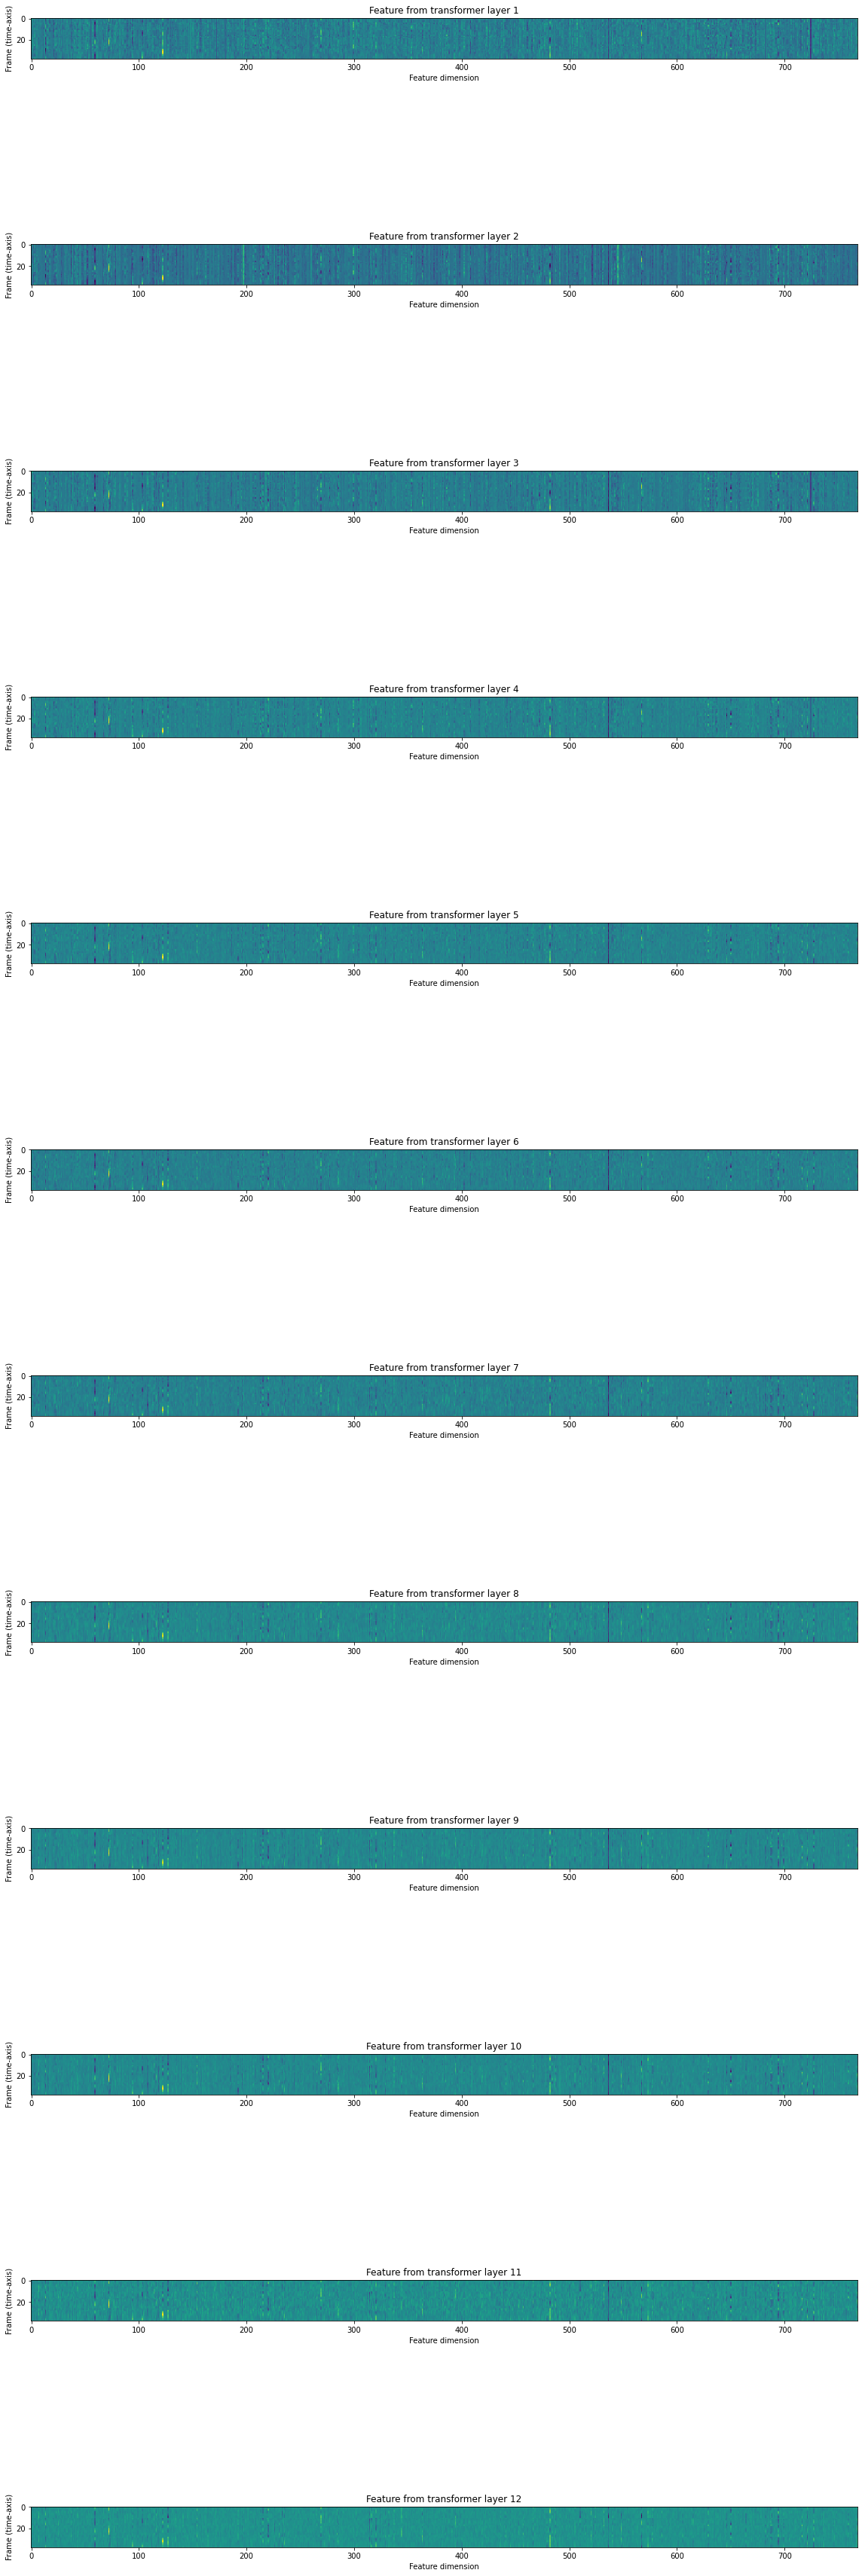

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [9]:
audios = []
labels = []

from tqdm import tqdm

for i in tqdm(range(len(entries))):
    entry = entries[i]
    path = DATA_NATURAL + "/" + entry
    if "wav" not in path:
      continue
    label = entry.split("_")[0]
    labels.append(label)
    wave, sr = torchaudio.load(path)
    wave = wave.to(device)
    if sr != bundle.sample_rate:
      wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
    with torch.inference_mode():
      features, _ = model.extract_features(wave)
    audios.append(features[0][0])

100%|██████████| 863/863 [04:14<00:00,  3.39it/s]


In [10]:
print(f'First audio shape: {audios[0].shape}')
print(f'First audio size: {audios[0].size(0)}')
print(f'Last audio torch size: {audios[-1].shape}')

First audio shape: torch.Size([38, 768])
First audio size: 38
Last audio torch size: torch.Size([43, 768])


In [11]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform):
        super(MyDataSet).__init__()
        self.data = data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return audio, length, label
    
    def __len__(self):
        return len(self.label)

In [12]:
categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Neutral']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happiness': 3,
 'Sadness': 4,
 'Neutral': 5}

In [13]:

def collate_indic(data):

    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    return features, lengths, labels

In [14]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(audios, labels, 
                                                    test_size=0.2, 
                                                    random_state=4800)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, 
                              collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, 
                             collate_fn=collate_indic)

In [15]:
for batch, data in enumerate(train_dataloader):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 109, 768])
1 torch.Size([64, 116, 768])
2 torch.Size([64, 65, 768])
3 torch.Size([64, 108, 768])
4 torch.Size([64, 83, 768])
5 torch.Size([64, 102, 768])
6 torch.Size([64, 107, 768])
7 torch.Size([64, 126, 768])
8 torch.Size([64, 111, 768])
9 torch.Size([64, 92, 768])
10 torch.Size([49, 64, 768])


## CNN Model Training

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits

In [17]:
from torchsummary import summary

model = ICASSP3CNN(768)

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
from tqdm import tqdm

epochs = 30
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)
    
    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f}, train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f}, valid loss:{valid_loss:.2f}")

  3%|▎         | 1/30 [00:56<27:07, 56.12s/it]

epoch:1, train accu:0.3149, train loss:1.64, valid accu:0.4971, valid loss:1.76


  7%|▋         | 2/30 [01:46<24:33, 52.64s/it]

epoch:2, train accu:0.6821, train loss:0.88, valid accu:0.6474, valid loss:1.34


 10%|█         | 3/30 [02:39<23:50, 52.99s/it]

epoch:3, train accu:0.8099, train loss:0.55, valid accu:0.7225, valid loss:0.81


 13%|█▎        | 4/30 [03:31<22:46, 52.55s/it]

epoch:4, train accu:0.8505, train loss:0.42, valid accu:0.6821, valid loss:0.85


 17%|█▋        | 5/30 [04:23<21:44, 52.16s/it]

epoch:5, train accu:0.9071, train loss:0.25, valid accu:0.7399, valid loss:0.82


 20%|██        | 6/30 [05:12<20:32, 51.34s/it]

epoch:6, train accu:0.9332, train loss:0.19, valid accu:0.7514, valid loss:0.82


 23%|██▎       | 7/30 [06:03<19:33, 51.04s/it]

epoch:7, train accu:0.9390, train loss:0.18, valid accu:0.7457, valid loss:0.89


 27%|██▋       | 8/30 [06:54<18:42, 51.03s/it]

epoch:8, train accu:0.9332, train loss:0.19, valid accu:0.7803, valid loss:0.77


 30%|███       | 9/30 [07:44<17:45, 50.74s/it]

epoch:9, train accu:0.9478, train loss:0.14, valid accu:0.7572, valid loss:0.90


 33%|███▎      | 10/30 [08:35<16:54, 50.72s/it]

epoch:10, train accu:0.9623, train loss:0.11, valid accu:0.7630, valid loss:0.87


 37%|███▋      | 11/30 [09:25<16:00, 50.53s/it]

epoch:11, train accu:0.9623, train loss:0.10, valid accu:0.7803, valid loss:0.82


 40%|████      | 12/30 [10:15<15:09, 50.51s/it]

epoch:12, train accu:0.9782, train loss:0.06, valid accu:0.7688, valid loss:1.01


 43%|████▎     | 13/30 [11:07<14:23, 50.81s/it]

epoch:13, train accu:0.9782, train loss:0.06, valid accu:0.7399, valid loss:1.20


 47%|████▋     | 14/30 [11:56<13:27, 50.50s/it]

epoch:14, train accu:0.9797, train loss:0.07, valid accu:0.7803, valid loss:0.86


 50%|█████     | 15/30 [12:48<12:42, 50.86s/it]

epoch:15, train accu:0.9855, train loss:0.05, valid accu:0.8092, valid loss:0.91


 53%|█████▎    | 16/30 [13:41<11:59, 51.37s/it]

epoch:16, train accu:0.9797, train loss:0.07, valid accu:0.7861, valid loss:0.92


 57%|█████▋    | 17/30 [14:32<11:08, 51.45s/it]

epoch:17, train accu:0.9826, train loss:0.07, valid accu:0.7688, valid loss:0.98


 60%|██████    | 18/30 [15:26<10:24, 52.08s/it]

epoch:18, train accu:0.9855, train loss:0.04, valid accu:0.7457, valid loss:0.97


 63%|██████▎   | 19/30 [16:18<09:33, 52.17s/it]

epoch:19, train accu:0.9855, train loss:0.05, valid accu:0.7225, valid loss:1.17


 67%|██████▋   | 20/30 [17:10<08:40, 52.00s/it]

epoch:20, train accu:0.9768, train loss:0.07, valid accu:0.8092, valid loss:0.91


 70%|███████   | 21/30 [18:09<08:08, 54.25s/it]

epoch:21, train accu:0.9884, train loss:0.03, valid accu:0.8266, valid loss:0.84


 73%|███████▎  | 22/30 [19:05<07:17, 54.65s/it]

epoch:22, train accu:0.9855, train loss:0.04, valid accu:0.8092, valid loss:1.02


 77%|███████▋  | 23/30 [20:01<06:26, 55.21s/it]

epoch:23, train accu:0.9956, train loss:0.02, valid accu:0.7803, valid loss:0.95


 80%|████████  | 24/30 [20:55<05:27, 54.61s/it]

epoch:24, train accu:0.9869, train loss:0.06, valid accu:0.7341, valid loss:1.22


 83%|████████▎ | 25/30 [21:48<04:31, 54.22s/it]

epoch:25, train accu:0.9739, train loss:0.09, valid accu:0.8150, valid loss:0.90


 87%|████████▋ | 26/30 [22:43<03:38, 54.52s/it]

epoch:26, train accu:0.9782, train loss:0.08, valid accu:0.6994, valid loss:1.31


 90%|█████████ | 27/30 [23:41<02:46, 55.39s/it]

epoch:27, train accu:0.9753, train loss:0.08, valid accu:0.7803, valid loss:1.12


 93%|█████████▎| 28/30 [24:33<01:49, 54.52s/it]

epoch:28, train accu:0.9869, train loss:0.05, valid accu:0.8324, valid loss:0.80


 97%|█████████▋| 29/30 [25:25<00:53, 53.74s/it]

epoch:29, train accu:0.9855, train loss:0.04, valid accu:0.8035, valid loss:0.98


100%|██████████| 30/30 [26:20<00:00, 52.67s/it]

epoch:30, train accu:0.9898, train loss:0.05, valid accu:0.7630, valid loss:0.98


In [ ]:
# model_path = '/content/drive/MyDrive/MESD/hubert_base.pth'

# torch.save({'epoch':epochs,
#             'model_state_dict':model.state_dict(),
#             'optimizer_state_dict':optimizer.state_dict()},
#             model_path)

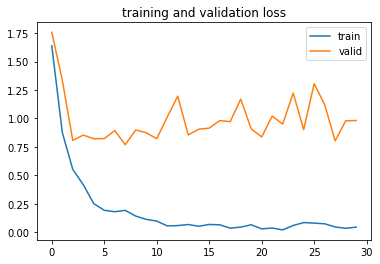

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss')
plt.show()

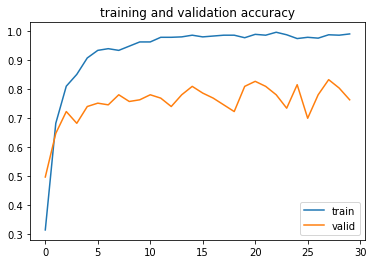

In [22]:
plt.plot(range(epochs), train_accuracies, label='train')
plt.plot(range(epochs), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy')
plt.show()

In [ ]:
# import pandas as pd
# from datetime import datetime

# now = datetime.now()

# metadata = pd.DataFrame({'epoch':range(epochs), 'train loss':train_losses, 
#                          'valid loss':valid_losses, 
#                          'train accu':train_accuracies, 
#                          'valid_accu':valid_accuracies})
# metadata.to_csv(f'/content/drive/MyDrive/MESD/hubert_base.csv', index=False)